# 特徴量の選択

## Greedy feature selection
貪欲法的に特徴量の追加と評価を繰り返す

1. それぞれの特徴量単体でモデルを評価し、最高精度の特徴量を選択する
2. 残りの特徴量を一つ追加し、モデルを評価し、残りの特徴量全てに実施し最高精度の特徴量を選択する
3. 2を最高精度を更新しなくなるまで繰り返す

計算量が高くなりやすいので注意が必要。高精度なモデルが必要な際に有効。

多項式特徴量と四則演算を用いた特徴量エンジニアリングを含む前処理を行う

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("data/penguins_size.csv")
# sexカラムの誤字 "." を欠損値に変更する
df.loc[df[df["sex"] == "."].index, "sex"] = np.nan
# 同じ行に欠損値が3つ以上ある場合はデータとしての情報が少ないのでdropしておく
df.dropna(thresh=3, inplace=True)

X = df.drop("species", axis=1)
y = df["species"]

# 欠損値代入
imputer = SimpleImputer(strategy="constant", fill_value="NaN")
imputer.set_output(transform="pandas")
imputer.fit_transform(X)

# one-hot encoding
# PipeLineに組み込むためのダミー変数生成クラスの自作--------------------
class GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# 特徴量エンジニアリング
# 多項式特徴量
poly = PolynomialFeatures(degree=2, include_bias=False)
X[["culmen_length_mm", "culmen_depth_mm", "culmen_length_mm^2", "culmen_depth_mm^2", "culmen_length_mm * culmen_depth_mm"]] = poly.fit_transform(X[["culmen_length_mm", "culmen_depth_mm"]])
# 四則演算
X["culmen_diff"] = X["culmen_length_mm"] - X["culmen_depth_mm"]
X["culmen_ratio"] = X["culmen_length_mm"] / X["culmen_depth_mm"]

# Pipeline
pipeline = Pipeline([("dummy", GetDummies()),
          ("scaler", StandardScaler()),
          ("model", LogisticRegression())])

# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)


#### GreedyFeatureSelectionを行うクラスを作成する

In [40]:
class GreedyFeatureSelection():
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        # 各 iteration 毎の score の履歴
        self.scores = [0]
        
    
    def select_feature(self, X, y):
        all_features = X.columns
        
        while True:
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                    
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                if score > best_score:
                    best_score = score
                    candidate_feature = feature
            
            if candidate_feature is not None:
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                # candidate_featureがない、つまり、最高精度を更新しない場合にループを終了する
                break

gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)

In [41]:
print(gfs.scores)
gfs.selected_features

[0, 0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]


['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']

### recursive feature elimination(RFE)

greedy feature selectionの逆で、全ての特徴量でモデルを構築してから特徴量を一つずつ減らしていく。

1. 全ての特徴量でモデルを学習する
2. モデルへの影響が最も低い特徴量を落とし、残りの特徴量でモデルを学習する
3. 2を、指定した特徴量になるまで実施する

線形回帰の係数(p値)や決定木の重要度などを使用する  
重要度などの指標を持ったモデルを使用する必要がある。  

In [42]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.transform(X)
print(rfe.ranking_)
# その特徴量が選択されたかどうかが rfe.support_ に格納されている
print(rfe.support_)
print(rfe.feature_names_in_)
rfe.feature_names_in_[rfe.support_]

[7 6 5 4 3 2 1 1 1 1 1 1]
[False False False False False False  True  True  True  True  True  True]
['culmen_length_mm' 'culmen_depth_mm' 'flipper_length_mm' 'body_mass_g'
 'culmen_length_mm^2' 'culmen_depth_mm^2'
 'culmen_length_mm * culmen_depth_mm' 'culmen_diff' 'culmen_ratio'
 'island_Dream' 'island_Torgersen' 'sex_MALE']


array(['culmen_length_mm * culmen_depth_mm', 'culmen_diff',
       'culmen_ratio', 'island_Dream', 'island_Torgersen', 'sex_MALE'],
      dtype=object)

In [43]:
# RFEで選別された特徴量を用いて学習する
pipeline = Pipeline([("rfe", rfe), ("scaler", StandardScaler()), ("model", LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)

[0.99122807 0.99122807 0.99122807]


RFECVを用いた場合

['culmen_diff' 'culmen_ratio' 'island_Dream']


<ErrorbarContainer object of 3 artists>

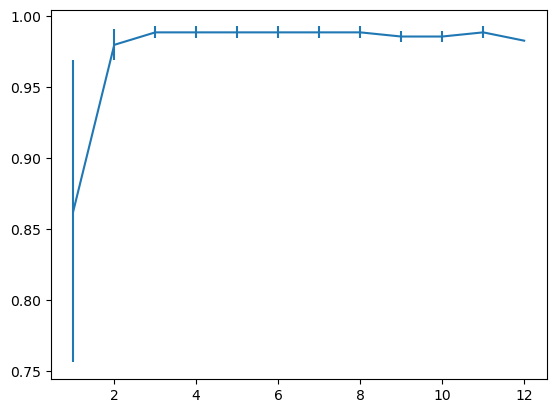

In [46]:
from sklearn.feature_selection import RFECV
# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)
rfecv = RFECV(estimator=DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)
print(rfecv.feature_names_in_[rfecv.support_])
plt.errorbar(range(1, 1+len(rfecv.cv_results_["mean_test_score"])),
             rfecv.cv_results_["mean_test_score"],
             yerr=rfecv.cv_results_["std_test_score"]
            )

3つ以上特徴量を増やしても精度が上がらないことがわかる。

In [47]:
# RFEで選別された特徴量を用いて学習する
pipeline = Pipeline([("rfe", rfe), ("scaler", StandardScaler()), ("model", LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)


[0.99122807 0.99122807 0.99122807]


## モデルの重要度から特徴量を選択する

In [64]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
sfm = SelectFromModel(RandomForestClassifier(random_state=0))
X_selected = sfm.fit_transform(X, y)

print("全ての特徴量の名前")
print(sfm.feature_names_in_)
print("各特徴量の重要度")
print(sfm.estimator_.feature_importances_)
# その特徴量が選択されたかどうかが sfm.get_support() に格納されている
print("各特徴量が選択されたかどうか")
print(sfm.get_support())
print("選択された特徴量")
print(sfm.feature_names_in_[sfm.get_support()])
print("選択されなかった特徴量")
print(sfm.feature_names_in_[~sfm.get_support()])

全ての特徴量の名前
['culmen_length_mm' 'culmen_depth_mm' 'flipper_length_mm' 'body_mass_g'
 'culmen_length_mm^2' 'culmen_depth_mm^2'
 'culmen_length_mm * culmen_depth_mm' 'culmen_diff' 'culmen_ratio'
 'island_Dream' 'island_Torgersen' 'sex_MALE']
各特徴量の重要度
[0.09446744 0.07327896 0.1224425  0.05185592 0.08431536 0.02614093
 0.05366813 0.19965974 0.18910682 0.10013683 0.00390842 0.00101895]
各特徴量が選択されたかどうか
[ True False  True False  True False False  True  True  True False False]
選択された特徴量
['culmen_length_mm' 'flipper_length_mm' 'culmen_length_mm^2' 'culmen_diff'
 'culmen_ratio' 'island_Dream']
選択されなかった特徴量
['culmen_depth_mm' 'body_mass_g' 'culmen_depth_mm^2'
 'culmen_length_mm * culmen_depth_mm' 'island_Torgersen' 'sex_MALE']


## L1正則化項(Lasso)による特徴量選択
λ を大きくするにつれて各特徴量の係数の絶対値が小さくなり、やがて 0 になる(**係数が0になった特徴量は選択されなかったということ**)  
特徴量同士のスケールが影響するので、事前に特徴量スケーリングが必要

In [63]:
l1sfm = SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear"))
pipeline = Pipeline([("scaler", StandardScaler()), ("feature selection", l1sfm)])
pipeline.set_output(transform="pandas")
pipeline.fit_transform(X, y)

print("全ての特徴量の名前")
print(l1sfm.feature_names_in_)
print("各特徴量の係数")
print(l1sfm.estimator_.coef_)
print("各特徴量が選択されたかどうか")
print(l1sfm.get_support())
print("選択された特徴量")
print(l1sfm.feature_names_in_[l1sfm.get_support()])
print("選択されなかった特徴量")
print(l1sfm.feature_names_in_[~l1sfm.get_support()])

全ての特徴量の名前
['culmen_length_mm' 'culmen_depth_mm' 'flipper_length_mm' 'body_mass_g'
 'culmen_length_mm^2' 'culmen_depth_mm^2'
 'culmen_length_mm * culmen_depth_mm' 'culmen_diff' 'culmen_ratio'
 'island_Dream' 'island_Torgersen' 'sex_MALE']
各特徴量の係数
[[ 0.          0.         -0.1821184   0.          0.          0.
   0.01556229 -6.81806463 -0.18110548 -0.35634024  0.88627686  1.1764737 ]
 [ 4.21378354  0.          0.         -2.36863853  0.          0.14624182
   0.          0.          0.          2.663117    0.         -0.75580557]
 [ 0.         -2.75521415  1.68573983  1.81079385  0.          0.
   0.          0.          0.52695006 -0.24927811  0.          0.        ]]
各特徴量が選択されたかどうか
[ True  True  True  True False  True  True  True  True  True  True  True]
選択された特徴量
['culmen_length_mm' 'culmen_depth_mm' 'flipper_length_mm' 'body_mass_g'
 'culmen_depth_mm^2' 'culmen_length_mm * culmen_depth_mm' 'culmen_diff'
 'culmen_ratio' 'island_Dream' 'island_Torgersen' 'sex_MALE']
選択されなかった特徴量
['culm